<a href="https://colab.research.google.com/github/kuds/rl-fetch/blob/main/Fetch/Pick%20and%20Place/%5BFetch%20Pick%20%26%20Place%5D%20Truncated%20Quantile%20Critics%20(TQC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Truncated Quantile Critics (TQC)

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
!pip install stable-baselines3 sb3-contrib

In [3]:
!pip install gymnasium-robotics

In [4]:
import torch
import datetime
import platform
from importlib.metadata import version
import gymnasium
import os
import numpy
import matplotlib
import matplotlib.pyplot
import gymnasium_robotics
import google.colab
from sb3_contrib import TQC
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Mujoco Version: {version('mujoco')}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Gymnasium Robotics Version: {version('gymnasium_robotics')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"SB3-Contrib Version: {version('sb3_contrib')}")

Python Version: 3.12.12
Torch Version: 2.8.0+cu126
Is Cuda Available: True
Cuda Version: 12.6
Mujoco Version: 3.3.7
Gymnasium Version: 1.2.1
Gymnasium Robotics Version: 1.4.1
Numpy Version: 2.0.2
Stable Baselines3 Version: 2.7.0
SB3-Contrib Version: 2.7.0


In [6]:
# Register Gymansium Robotics Environment
gymnasium.register_envs(gymnasium_robotics)

In [7]:
rl_type = "TQC"
env_str = "FetchPickAndPlaceDense-v4"
name_prefix = f"{env_str}_{rl_type}".lower()
log_dir = "./logs/{}/{}".format(env_str, rl_type)

In [8]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (25,), float64))
Actions Space:  Box(-1.0, 1.0, (4,), float32)


In [9]:
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/tqc.yml
# FetchPush-v1: &her-defaults
#   n_timesteps: !!float 1e6
#   policy: 'MultiInputPolicy'
#   buffer_size: 1000000
#   batch_size: 2048
#   gamma: 0.95
#   learning_rate: !!float 1e-3
#   tau: 0.05
#   replay_buffer_class: HerReplayBuffer
#   replay_buffer_kwargs: "dict(
#     goal_selection_strategy='future',
#     n_sampled_goal=4,
#   )"
#   policy_kwargs: "dict(net_arch=[512, 512, 512], n_critics=2)"

In [10]:
# Create Training environment
env = make_vec_env(env_str,
                   n_envs=4,
                   monitor_dir=os.path.join(log_dir, "monitor"))

# Create Evaluation environment
env_val = make_vec_env(env_str, n_envs=1)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Instantiate the agent
model = TQC("MultiInputPolicy", env,
            verbose=0,
            learning_starts=1_000,  # Set to a value >= max episode length
            buffer_size=1_000_000,
            tau=0.05,
            learning_rate=1e-3,
            gamma=0.95,
            batch_size=2048,
            policy_kwargs=dict(net_arch=[512, 512, 512], n_critics=2),
            replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=dict(
                goal_selection_strategy=GoalSelectionStrategy.FUTURE,
                n_sampled_goal=4,
            ),
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the agent with the callback
model.learn(total_timesteps=1_000_000,
            callback=eval_callback,
            progress_bar=False)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Final Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close the environment
env.close()
env_val.close()

Eval num_timesteps=100000, episode_reward=-13.50 +/- 6.16
Episode length: 50.00 +/- 0.00
Success rate: 0.00%
New best mean reward!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=200000, episode_reward=-6.22 +/- 5.05
Episode length: 50.00 +/- 0.00
Success rate: 40.00%
New best mean reward!
Eval num_timesteps=300000, episode_reward=-3.03 +/- 1.47
Episode length: 50.00 +/- 0.00
Success rate: 90.00%
New best mean reward!
Eval num_timesteps=400000, episode_reward=-2.86 +/- 1.66
Episode length: 50.00 +/- 0.00
Success rate: 95.00%
New best mean reward!
Eval num_timesteps=500000, episode_reward=-4.11 +/- 7.49
Episode length: 50.00 +/- 0.00
Success rate: 90.00%
Eval num_timesteps=600000, episode_reward=-2.24 +/- 1.06
Episode length: 50.00 +/- 0.00
Success rate: 100.00%
New best mean reward!
Eval num_timesteps=700000, episode_reward=-2.60 +/- 1.05
Episode length: 50.00 +/- 0.00
Success rate: 100.00%
Eval num_timesteps=800000, episode_reward=-2.03 +/- 0.85
Episode length: 50.00 +/- 0.00
Success rate: 100.00%
New best mean reward!
Eval num_timesteps=900000, episode_reward=-1.93 +/- 0.85
Episode length: 50.00 +/- 0.00
Success rate: 100.00%
New best mean 

In [11]:
# Create Evaluation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model")
best_model = TQC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=10_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

n_sims = 5
obs = env.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        n_sims = n_sims - 1
        if n_sims == 0:
            break
        obs = env.reset()

env.close()

Best Model - Mean reward: -2.07 +/- 1.04
Moviepy - Building video /content/logs/FetchPickAndPlaceDense-v4/TQC/best_model_fetch_pick_and_place _tqc-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/FetchPickAndPlaceDense-v4/TQC/best_model_fetch_pick_and_place _tqc-step-0-to-step-10000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
                                                               

Moviepy - Done !
Moviepy - video ready /content/logs/FetchPickAndPlaceDense-v4/TQC/best_model_fetch_pick_and_place _tqc-step-0-to-step-10000.mp4


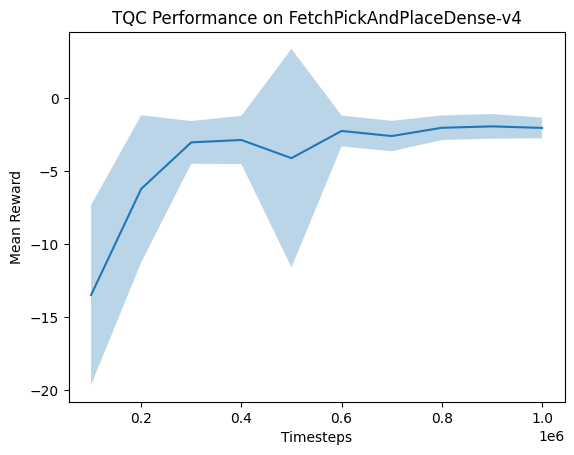

In [12]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.savefig(os.path.join(log_dir, f"{rl_type}_{env_str}_performance.png"))
matplotlib.pyplot.show()